In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import statistics
import numpy as np

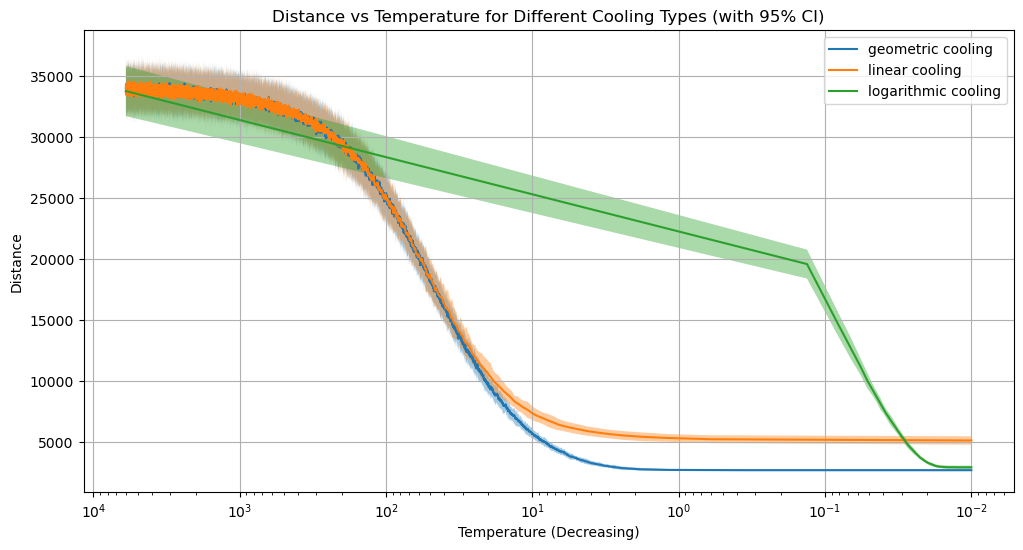

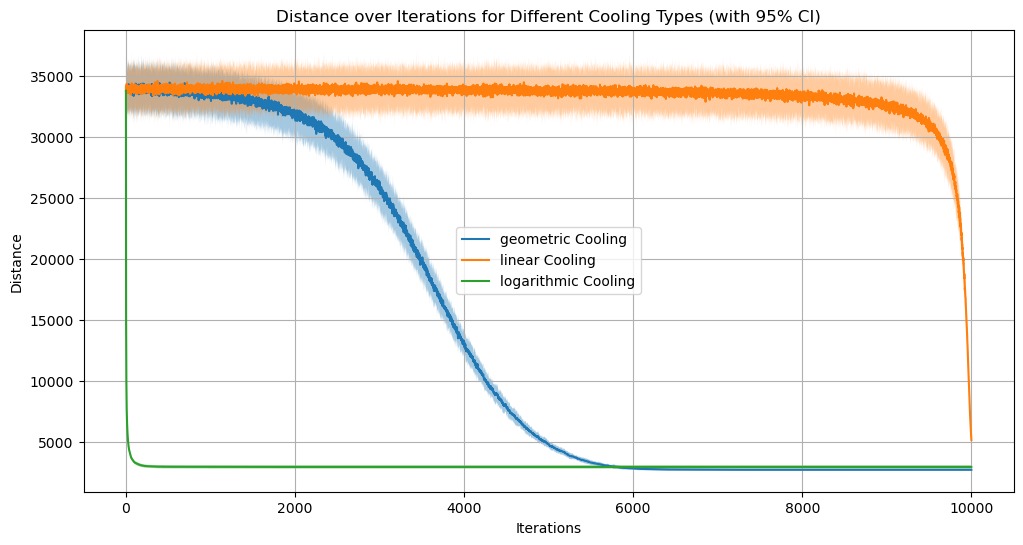

In [26]:
# Parameters
csv_filename = 'simulation_results_eil51_6000_800_cooling_types_a280.csv'
cooling_types_of_interest = ["logarithmic","linear","geometric"]

# Read the CSV
df = pd.read_csv(csv_filename)

# Convert 'Distances', 'Temperatures', and 'Iterations' from string to list
df['Distances'] = df['Distances'].str.strip("[]").str.split(", ").apply(lambda x: list(map(float, x)))
df['Temperatures'] = df['Temperatures'].str.strip("[]").str.split(", ").apply(lambda x: list(map(float, x)))
df['Iterations'] = df['Iterations'].str.strip("[]").str.split(", ").apply(lambda x: list(map(int, x)))

# Filter for the desired cooling types
df = df[df['Cooling Type'].isin(cooling_types_of_interest)]

# Group data by cooling type
cooling_types = df['Cooling Type'].unique()

aggregated = {}
for ct in cooling_types:
    subset = df[df['Cooling Type'] == ct]
    if len(subset) == 0:
        continue
    
    # Convert all runs distances and temperatures into DataFrames
    dist_df = pd.DataFrame(subset['Distances'].tolist())       # rows = runs, cols = iterations
    temp_df = pd.DataFrame(subset['Temperatures'].tolist())    # rows = runs, cols = iterations
    iter_df = pd.DataFrame(subset['Iterations'].tolist())      # rows = runs, cols = iterations

    n_runs = len(subset)

    # Compute mean and CI for distances and temperatures at each iteration
    dist_mean = dist_df.mean(axis=0)
    dist_std = dist_df.std(axis=0)
    dist_lower = dist_mean - 2 * dist_std
    dist_upper = dist_mean + 2 * dist_std

    # Compute average max iterations
    max_iterations = iter_df.apply(lambda x: x.iloc[-1], axis=1)[0]

    aggregated[ct] = {
        'dist_mean': dist_mean,
        'dist_lower': dist_lower,
        'dist_upper': dist_upper,
        'temp': temp_df.iloc[2],
        'iterations': range(len(dist_mean)),
        'max_iterations': max_iterations,
        'n_runs': n_runs,
        'dist_df': dist_df
    }

# Plot Distance vs Temperature with CI
plt.figure(figsize=(12, 6))
for ct, data in aggregated.items():
    plt.plot(data['temp'], data['dist_mean'], label=f'{ct} cooling')
    plt.fill_between(data['temp'], data['dist_lower'], data['dist_upper'], alpha=0.4)
plt.title('Distance vs Temperature for Different Cooling Types (with 95% CI)')
plt.xlabel('Temperature (Decreasing)')
plt.ylabel('Distance')
plt.xscale('log')  
plt.gca().invert_xaxis()  # Reverse x-axis for decreasing temperature
plt.legend()
plt.grid(True)
plt.show()

# Plot Distance vs Iteration with CI
plt.figure(figsize=(12, 6))
for ct, data in aggregated.items():
    it = data['iterations']
    plt.plot(it, data['dist_mean'], label=f'{ct} Cooling')
    plt.fill_between(it, data['dist_lower'], data['dist_upper'], alpha=0.4)
plt.title('Distance over Iterations for Different Cooling Types (with 95% CI)')
plt.xlabel('Iterations')
plt.ylabel('Distance')
plt.legend()
plt.grid(True)
plt.show()



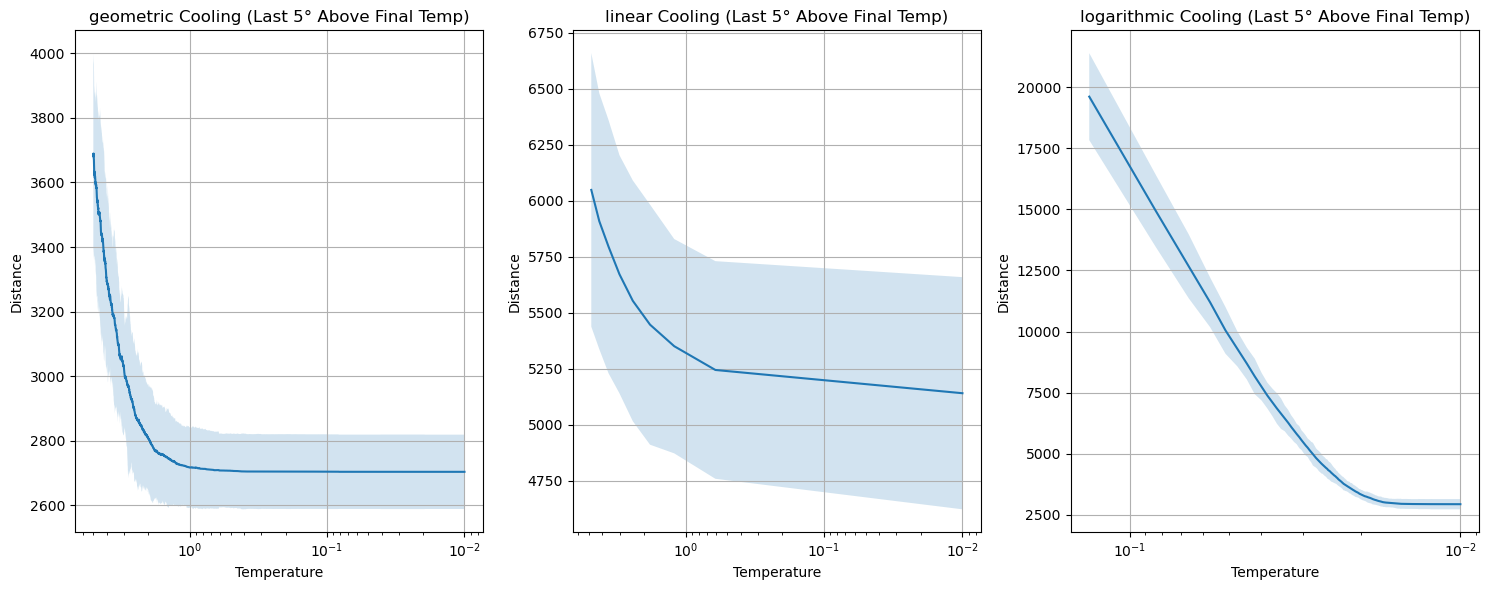

In [24]:
# Zoom in on the last 5 degrees of temperature: Separate subplots for each cooling type
num_ct = len(aggregated)
fig, axes = plt.subplots(nrows=1, ncols=num_ct, figsize=(5 * num_ct, 6))

if num_ct == 1:
    # If there's only one cooling type, just use axes directly
    axes = [axes]

for ax, (ct, data) in zip(axes, aggregated.items()):
    temp_mean = data['temp']
    dist_mean = data['dist_mean']
    dist_lower = data['dist_lower']
    dist_upper = data['dist_upper']

    # Identify final temperature (lowest temperature)
    final_temp = temp_mean.iloc[-1]
    # Define cutoff as final_temp + 5
    cutoff_temp = final_temp + 5

    # Get indices where temperature <= cutoff_temp
    indices = [i for i, t in enumerate(temp_mean) if t <= cutoff_temp]

    if len(indices) > 0:
        start_idx = indices[0]
        # Plot only this section
        ax.plot(temp_mean[start_idx:], dist_mean[start_idx:], label=f'{ct} Cooling')
        ax.fill_between(temp_mean[start_idx:], dist_lower[start_idx:], dist_upper[start_idx:], alpha=0.2)

    ax.set_title(f'{ct} Cooling (Last 5° Above Final Temp)')
    ax.set_xlabel('Temperature')
    ax.set_ylabel('Distance')
    ax.set_xscale('log')
    ax.invert_xaxis()
    ax.grid(True)
    #ax.legend()

plt.tight_layout()
plt.show()


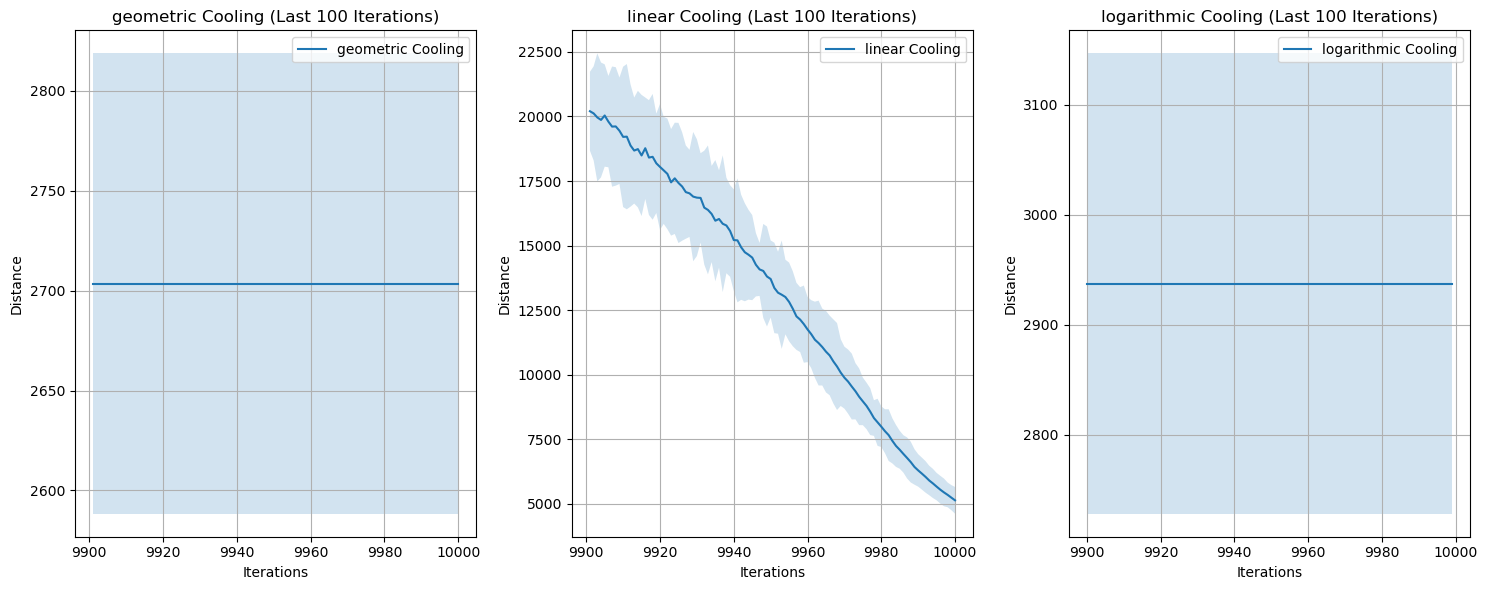

In [25]:
# Zoom in on last 100 iterations: Separate subplots for each cooling type
num_ct = len(aggregated)
fig, axes = plt.subplots(nrows=1, ncols=num_ct, figsize=(5 * num_ct, 6))

if num_ct == 1:
    # If there's only one cooling type, wrap it in a list
    axes = [axes]

for ax, (ct, data) in zip(axes, aggregated.items()):
    dist_mean = data['dist_mean']
    dist_lower = data['dist_lower']
    dist_upper = data['dist_upper']
    iterations = list(data['iterations'])

    # Determine the starting index for the last 100 iterations
    start_idx = max(0, len(dist_mean)-100)

    # Plot the last 100 iterations
    ax.plot(iterations[start_idx:], dist_mean[start_idx:], label=f'{ct} Cooling')
    ax.fill_between(iterations[start_idx:], dist_lower[start_idx:], dist_upper[start_idx:], alpha=0.2)

    ax.set_title(f'{ct} Cooling (Last 100 Iterations)')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Distance')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
